In [1]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import vmap, jit
import matplotlib.pyplot as plt
import joblib
from qdots_qll.models import game
from qdots_qll import all_funcs
import seaborn as sns
import pandas as pd
import scipy
from functools import reduce

import matplotlib.font_manager as font_manager

import equinox as eqx

# from matplotlib import rcParams
from scipy.stats import binned_statistic


font = {"family": "Inter"}  # , 'weight': 'normal', 'size': 12}

# Aplica la fuente definida a Matplotlib
plt.rc("font", **font)

sns.set_palette("colorblind")

In [2]:
def compute_mean_one_run(cum_times_i, cov_arr_i, limites_bins):
    indices_bins = np.digitize(cum_times_i, limites_bins)
    means = np.array(
        [
            np.nanmean(cov_arr_i[indices_bins == i], axis=0)
            for i in range(1, len(limites_bins))
        ]
    )

    std_devs = np.array(
        [
            np.nanstd(cov_arr_i[indices_bins == i], axis=0)
            for i in range(1, len(limites_bins))
        ]
    )
    return means, std_devs

In [3]:
names_true = [
    "$\\gamma ( - \\eta)$",
    "$\\gamma ( + \\eta)$",
    "$S ( - \\eta)$",
    "$S ( +\\eta)$",
]
names_hat = [
    "$\\hat{\\gamma} ( - \\eta)$",
    "$\\hat{\\gamma} ( + \\eta)$",
    "$\\hat{S} ( - \\eta)$",
    "$\\hat{S} ( +\\eta)$",
]

In [4]:
def get_binned_results_from_runs(times_array, cov_array,
    bin_step,
):
    cum_times = np.array(times_array[:, 1:]).cumsum(axis=1)
    cum_times_flatten = cum_times.flatten()
    cov_flatten = np.array(cov_array[:, 1:]).reshape(-1, 4, 4)
    bins = np.arange(
        cum_times_flatten.min(), cum_times_flatten.max() + 1, bin_step
    )

    mean_list = []
    std_list = []

    for i in range(4):
        mean_row_list = []
        std_row_list = []

        for j in range(4):

            mean_row_list.append(
                binned_statistic(
                    cum_times_flatten,
                    cov_flatten[:, i, j],
                    statistic="mean",
                    bins=bins,
                )[0]
            )
            std_row_list.append(
                binned_statistic(
                    cum_times_flatten,
                    cov_flatten[:, i, j],
                    statistic="std",
                    bins=bins,
                )[0]
            )
        mean_list.append(mean_row_list)
        std_list.append(std_row_list)
    mean_list = np.array(mean_list).transpose(2, 1, 0)
    std_list = np.array(std_list).transpose(2, 1, 0)

    cum_times_binned, _, _ = binned_statistic(
        cum_times_flatten, cum_times_flatten, statistic="mean", bins=bins
    )
    return cum_times_binned, mean_list, std_list

In [5]:
from qdots_qll.utils.generate_initial_state import max_entangled_dm_vec
from qdots_qll.models.models_scratch_for_drafting import (
    two_qdots_separable_maps,)
from qbism import sic_povm
from qdots_qll.models.game import true_pars



In [6]:
initial_state = max_entangled_dm_vec

In [7]:
m =  two_qdots_separable_maps(POVM_array=jnp.array(sic_povm(4)))

In [12]:
df = joblib.load("../results_cluster/run_2024-03-15_16:05:15_results.job")

In [29]:
# df = None

In [23]:
particles = df.particles_locations[0, 0]
weights = df.weights[0, 0]

In [24]:
def est_fim(t, particles, weights, model, initial_state):
    fim_particles = jax.vmap(lambda par, t: model.fim(par, t, initial_state), in_axes=(0, None))(particles, t)
    e_fim = jnp.einsum('i, ijk', weights, fim_particles)
    return e_fim

In [25]:
times = jnp.linspace(0, 100, 1000)

In [27]:
weights.shape

(2000,)

In [30]:
fim_times = vmap(lambda a: (m.fim(true_pars, a, initial_state, )), in_axes=(0))(times)
inv_fim_times = vmap(lambda a: jnp.linalg.inv(m.fim(true_pars, a, initial_state )), in_axes=(0))(times)
det_fim_times = vmap(lambda a: jnp.linalg.det(m.fim(true_pars, a, initial_state )), in_axes=(0))(times)

e_fim_times = jax.vmap(lambda t: est_fim(t, particles, weights, m, initial_state))(times)


2024-03-18 17:07:21.299170: W external/tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.83GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 4112777216 bytes.

(0.0, 40.0)

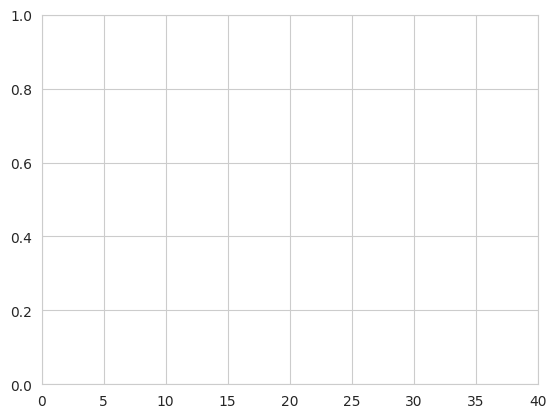

In [134]:
plt.xlim(0, 40)

In [137]:
(1/fim_times).shape

(1000, 4, 4)

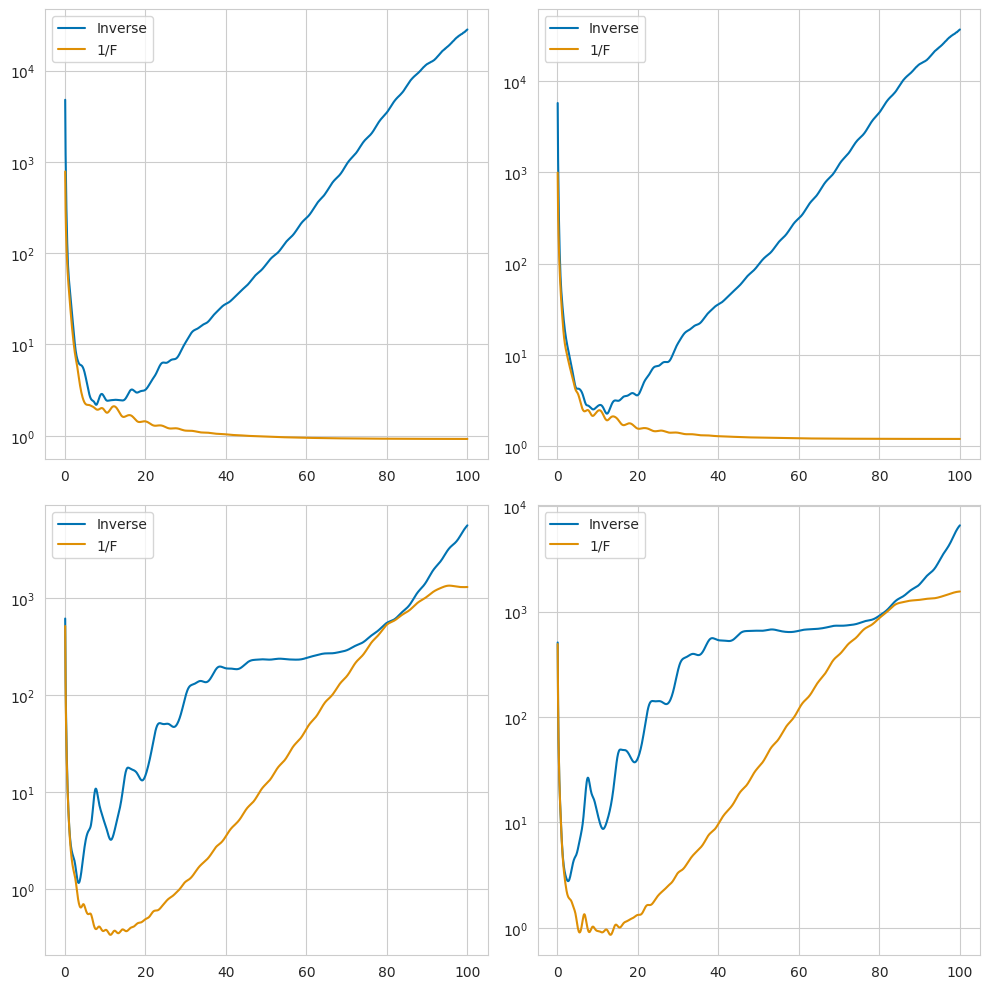

In [165]:

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for i, ax in enumerate(axs.flat):
    
    
    # ax.plot(times, fim_times[:, i, i], label="F")
    ax.plot(times, inv_fim_times[:, i, i], label="Inverse")
    ax.plot(times, 1/fim_times[:, i, i], label="1/F")
    # ax.axvline( jnp.min(inv_fim_times[:, i, i]))
    ax.set_yscale('log')
    ax.legend()
plt.tight_layout()
plt.show()

In [162]:
jnp.nanmin(vmap(lambda x: jnp.diag(x))(1/fim_times), axis=0)

Array([0.92438275, 1.2021239 , 0.33542874, 0.85845524], dtype=float32)

In [161]:
jnp.nanmin(vmap(lambda x: jnp.diag(x))(inv_fim_times), axis=0)

Array([2.1851208, 2.2743912, 1.1511817, 2.7714214], dtype=float32)

In [158]:
inv_fim_times[:, i, i]

Array([           inf, 5.09685852e+02, 1.32957642e+02, 6.24874344e+01,
       3.75976486e+01, 2.59255676e+01, 1.94059696e+01, 1.52459421e+01,
       1.22944288e+01, 1.00531015e+01, 8.31127071e+00, 6.96861267e+00,
       5.95231724e+00, 5.19383192e+00, 4.63074493e+00, 4.21123838e+00,
       3.89520812e+00, 3.65291357e+00, 3.46289802e+00, 3.31009221e+00,
       3.18424296e+00, 3.07868433e+00, 2.98941827e+00, 2.91451430e+00,
       2.85371661e+00, 2.80814981e+00, 2.77990246e+00, 2.77142143e+00,
       2.78483939e+00, 2.82144022e+00, 2.88145924e+00, 2.96413779e+00,
       3.06791568e+00, 3.19057417e+00, 3.32931209e+00, 3.48071146e+00,
       3.64071989e+00, 3.80466199e+00, 3.96732640e+00, 4.12321758e+00,
       4.26701832e+00, 4.39429855e+00, 4.50258732e+00, 4.59253025e+00,
       4.66888142e+00, 4.74043703e+00, 4.81851578e+00, 4.91427803e+00,
       5.03599310e+00, 5.18764019e+00, 5.36912107e+00, 5.57754755e+00,
       5.80874491e+00, 6.05831766e+00, 6.32246161e+00, 6.59842300e+00,
      

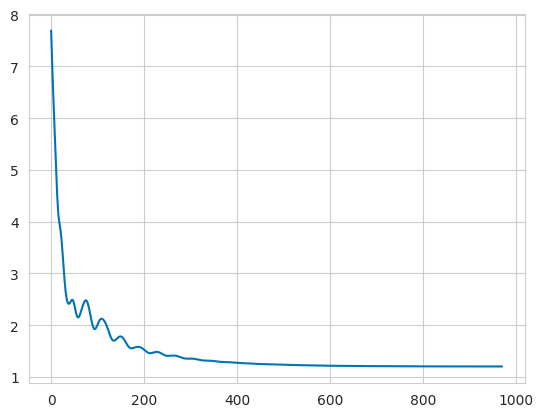

In [141]:
plt.plot(1/fim_times[30:,1, 1])

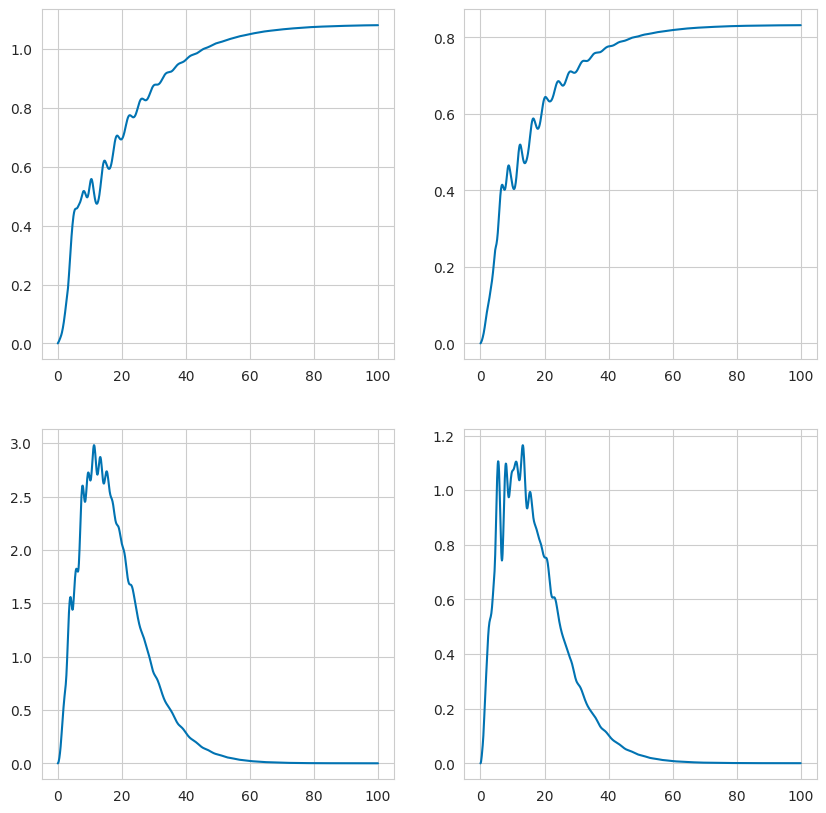

In [135]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for i, ax in enumerate(axs.flat):
    ax.plot(times, fim_times[:, i, i ])

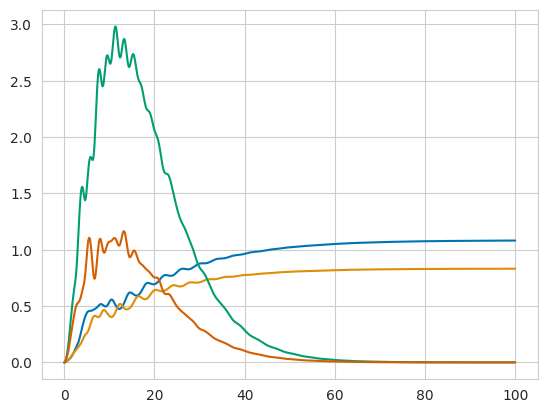

In [133]:
for i in range(4):
    plt.plot(times, fim_times[:, i, i], label="")

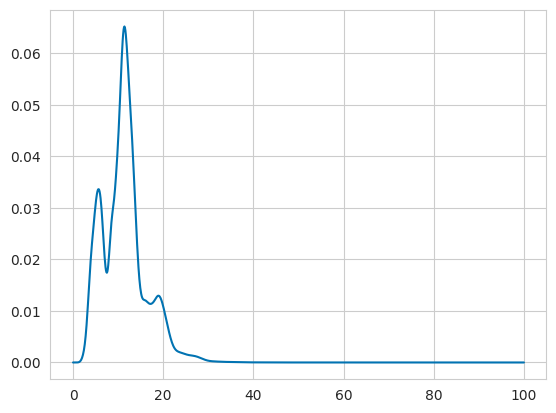

In [129]:
plt.plot(times, det_fim_times)


<Axes: ylabel='Count'>

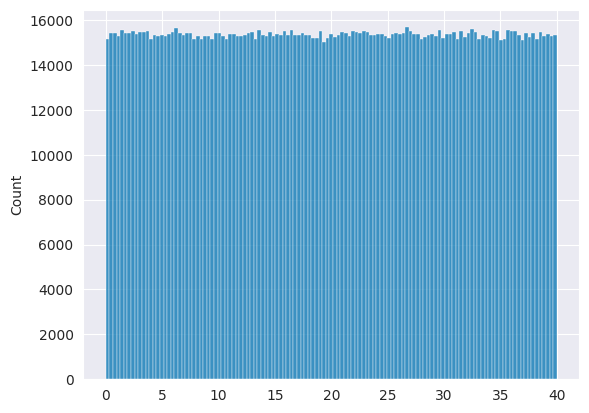

In [122]:
sns.histplot(np.array(df.times_array[:, 0]).flatten())

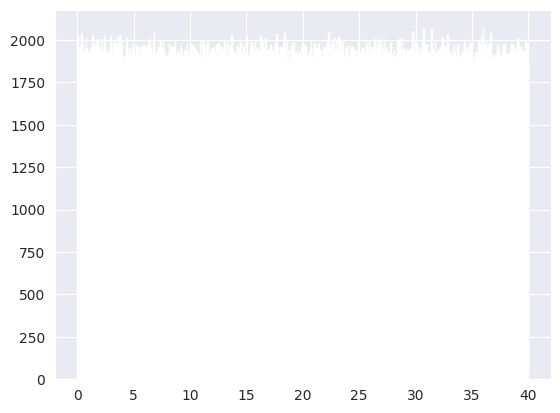

In [116]:
plt.hist(np.array(df.times_array[:, 0]).flatten(), bins=1000)
plt.show()

In [ ]:
model = 

In [111]:
cum_times_binned, mean_list, std_list = get_binned_results_from_runs(df.times_array[:, 0], df.cov_array[:, 0], 100)

In [92]:
print(df)

Run(
  iteration=i32[96,1],
  key=u32[96,1,2],
  time=f32[96,1],
  weights=f32[96,1,2000],
  particles_locations=f32[96,1,2000,4],
  times_array=f32[96,1,20000],
  estimates_array=f32[96,1,20000,4],
  cov_array=f32[96,1,20000,4,4],
  max_iterations=i32[96,1],
  min_iterations=i32[96,1],
  std_threshold=f32[96,1]
)


In [5]:
# big_prior_opt_results = joblib.load(
#     "../results/run_2024-03-11_11:58:26_results.job"
# )
# big_prior_opt_model = joblib.load(
#     "../results/run_2024-03-11_11:58:26_model.job"
# )
# m = big_prior_opt_model
# 
# 
# small_prior_opt_results = joblib.load(
#     "../results/run_2024-03-11_11:50:11_results.job"
# )
# small_prior_opt_model = joblib.load(
#     "../results/run_2024-03-11_11:50:11_model.job"
# )
# 
# big_prior_rand_results = joblib.load(
#     "../results/run_2024-03-11_16:10:16_results.job"
# )
# big_prior_rand_model = joblib.load(
#     "../results/run_2024-03-11_16:10:16_model.job"
# )
# 
# 
# small_prior_rand_results = joblib.load(
#     "../results/run_2024-03-11_17:03:46_results.job"
# )
# 
# small_prior_rand_model = joblib.load(
#     "../results/run_2024-03-11_17:03:46_model.job"
# )

In [9]:
from equinox import tree_at

In [ ]:
tree_at()

In [13]:
from equinox import apply_updates

In [32]:
df

Run(
  iteration=i32[96,1],
  key=u32[96,1,2],
  time=f32[96,1],
  weights=f32[96,1,2000],
  particles_locations=f32[96,1,2000,4],
  times_array=f32[96,1,20000],
  estimates_array=f32[96,1,20000,4],
  cov_array=f32[96,1,20000,4,4],
  max_iterations=i32[96,1],
  min_iterations=i32[96,1],
  std_threshold=f32[96,1]
)

In [26]:
df.cov_array.reshape(-2, df.cov_array.shape[-2])

TypeError: cannot reshape array of shape (96, 1, 20000, 4, 4) (size 30720000) into shape (-2, 4) (size -8)

In [44]:
eqx.tree_flatten_one_level(df)[0][4].shape

(96, 1, 2000, 4)

In [82]:
reshape_f = lambda x: x.reshape(-1, *x.shape[2:])

jax.tree_map(reshape_f, df.times_array)

Array([[0.0000000e+00, 2.6241707e+01, 1.7440678e+01, ..., 1.6604601e+01,
        6.7143755e+00, 1.2676430e+01],
       [0.0000000e+00, 3.5314648e+01, 1.3785409e+01, ..., 2.4591772e+01,
        6.5664887e-01, 1.9359005e+01],
       [0.0000000e+00, 1.8492390e+01, 1.3602244e+01, ..., 3.4165306e+01,
        1.4104496e+01, 9.0128336e+00],
       ...,
       [0.0000000e+00, 3.4505611e+01, 2.2607046e+01, ..., 3.0362251e+01,
        2.7584364e+00, 2.6738422e+01],
       [0.0000000e+00, 2.2136621e+00, 2.7515440e+01, ..., 2.1998163e+01,
        1.1629995e+01, 1.4230349e+00],
       [0.0000000e+00, 1.5768570e+01, 1.3899553e-02, ..., 2.0555630e+01,
        3.5685581e+01, 1.0221151e+01]], dtype=float32)

[]

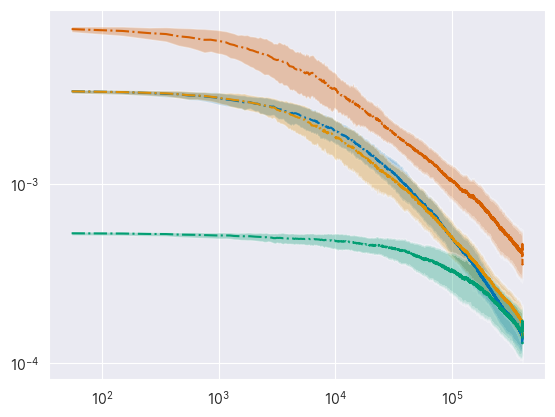

In [112]:
for i in range(4):
    plt.plot(cum_times_binned, mean_list[:, i, i], "-.")
    plt.fill_between(
        cum_times_binned,
        mean_list[:, i, i] - std_list[:, i, i],
        mean_list[:, i, i] + std_list[:, i, i],
        alpha=0.3,
    )
plt.loglog()

In [235]:
all_df = [
    big_prior_opt_results,
    small_prior_opt_results,
    big_prior_rand_results,
    small_prior_rand_results,
]
info_list = [
    "big prior opt",
    "small prior opt",
    "big prior random",
    "small prior random",
]

In [257]:
all_results_binned = [
    get_binned_results_from_runs(df_i, 200) for df_i in all_df
]

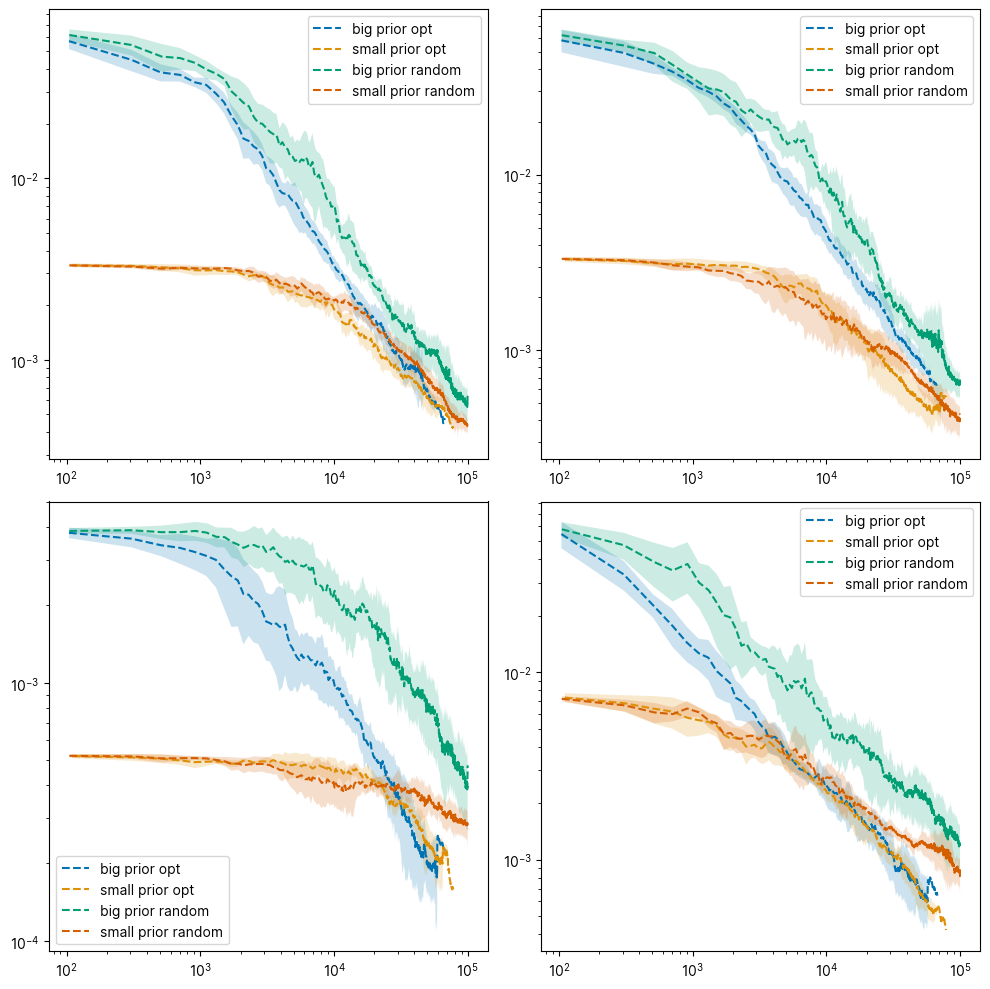

In [269]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for j, ax in enumerate(axs.flat):

    for i in range(4):
        ax.plot(
            all_results_binned[i][0],
            all_results_binned[i][1][:, j, j],
            "--",
            # ms=0.8,
            label=info_list[i],
        )
        ax.fill_between(
            all_results_binned[i][0],
            all_results_binned[i][1][:, j, j]
            + all_results_binned[i][2][:, j, j],
            all_results_binned[i][1][:, j, j]
            - all_results_binned[i][2][:, j, j],
            alpha=0.2,
        )

        #
        ax.legend()

        ax.loglog()

# plt.legend()
# plt.xscale('log')
# plt.yscale('log')
plt.tight_layout()
plt.show()

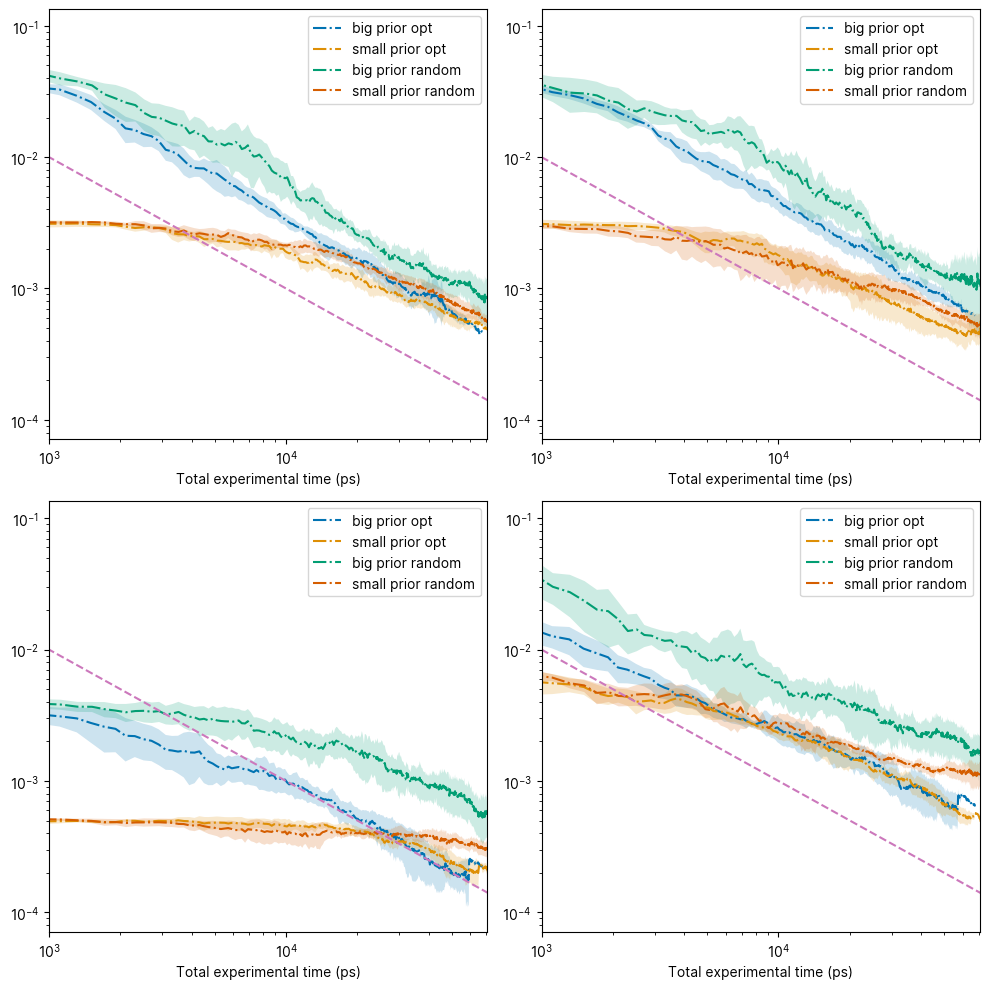

In [270]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for j, ax in enumerate(axs.flat):

    for i in range(4):
        ax.plot(
            all_results_binned[i][0],
            all_results_binned[i][1][:, j, j],
            "-.",
            # ms=0.8,
            label=info_list[i],
        )

        ax.fill_between(
            all_results_binned[i][0],
            all_results_binned[i][1][:, j, j]
            + all_results_binned[i][2][:, j, j],
            all_results_binned[i][1][:, j, j]
            - all_results_binned[i][2][:, j, j],
            alpha=0.2,
        )
        #
        ax.legend()
        ax.set_xlabel("Total experimental time (ps)")
        ax.set_xlim(1000)

    ax.plot(all_results_binned[i][0], 10 / all_results_binned[i][0], "--")
    ax.loglog()

# plt.legend()
# plt.xscale('log')
# plt.yscale('log')
plt.tight_layout()
plt.show()

In [280]:
particles = np.array(arr.particles_locations[0][:, :])
weights = np.array(arr.weights[0])

In [286]:
particles[:, 0]

array([0.33713898, 0.35848066, 0.37889543, ..., 0.34442228, 0.39145318,
       0.40048626], dtype=float32)

In [288]:
np.argsort(particles[:, 0])

array([ 858, 1173, 1364, ..., 1251, 1228, 1004])

In [383]:
i = 0
sort_pars_axis = np.sort(
    particles[:, i],
)
sort_indexes = np.argsort(particles[:, i])

In [304]:
# finite_diff_weights = sort_pars_axis[1:] - weights[sort_indexes][0:-1]

# denominator_finite_diff = np.abs(
#     sort_pars_axis[1:] - np.abs(sort_pars_axis[0:-1])
# )

# finite_diff = finite_diff_weights / denominator_finite_diff

In [373]:
sort_pars_axis

array([0.28893307, 0.29236436, 0.29365298, ..., 0.45827767, 0.4587764 ,
       0.46369135], dtype=float32)

In [375]:
sort_pars_axis.shape

(2000,)

In [378]:
np.gradient(aux.pdf(particles[:, i]))

array([-6.53380239,  0.72444299,  3.95591951, ...,  1.43830965,
       -1.66085115,  0.61751535])

In [382]:
aux.pdf(sort_pars_axis)

array([0., 0., 0., ..., 0., 0., 0.])

In [381]:
sort_pars_axis

array([0.28893307, 0.29236436, 0.29365298, ..., 0.45827767, 0.4587764 ,
       0.46369135], dtype=float32)

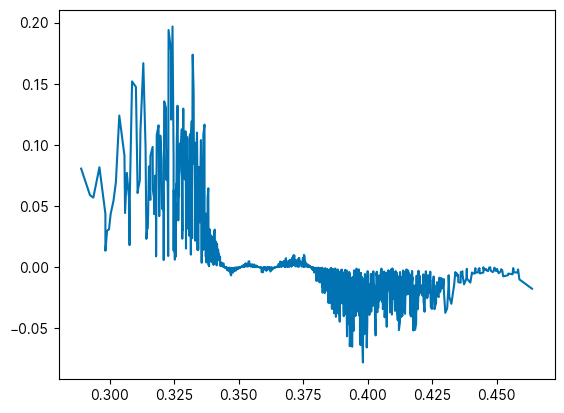

In [340]:
finite_diff_weights = (
    -weights[sort_indexes][2:]
    + 4 * weights[sort_indexes][1:-1]
    - 3 * weights[sort_indexes][0:-2]
)

denominator_finite_diff = np.abs(sort_pars_axis[2:] - (sort_pars_axis[0:-2]))

finite_diff = finite_diff_weights / denominator_finite_diff

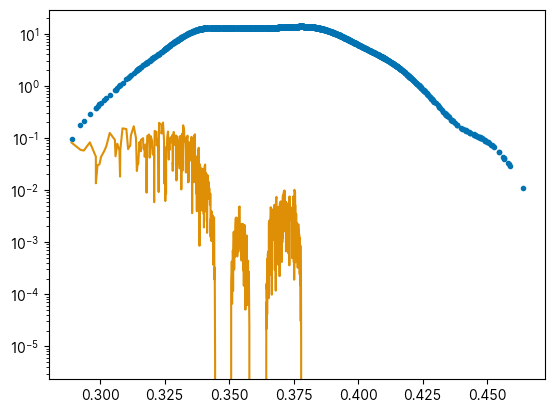

In [393]:
from scipy.stats import gaussian_kde

i = 0
aux = gaussian_kde(particles[:, i], weights=weights)
plt.plot(particles[:, i], aux.pdf(particles[:, i]), ".")

# plt.plot(particles[:, i], np.gradient(aux.pdf(particles[:, i])))\
plt.plot(sort_pars_axis, np.gradient(aux.pdf(sort_pars_axis)))
plt.yscale("log")

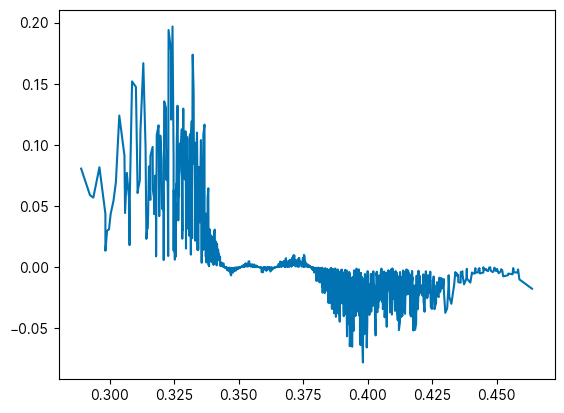

In [391]:
plt.plot(sort_pars_axis, np.gradient(aux.pdf(sort_pars_axis)))

In [358]:
aux.pdf(particles[:, 0])

array([11.55724774, 12.99472562, 13.65304391, ..., 13.01219044,
        9.84434496,  5.92959757])

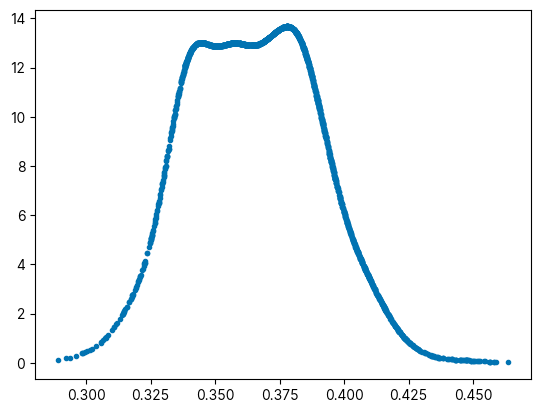

In [349]:
weights

array([1.0411928e-03, 2.0489396e-04, 8.8691292e-04, ..., 4.7467925e-04,
       5.5402599e-04, 3.6970334e-05], dtype=float32)

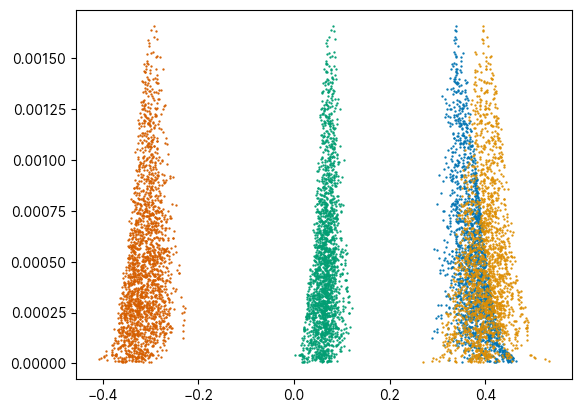

In [341]:
for i in range(4):
    plt.plot(particles[:, i], weights[:], ".", ms=1.3)

In [342]:
sort_pars_axis.shape

(2000,)

In [343]:
finite_diff.shape

(1998,)

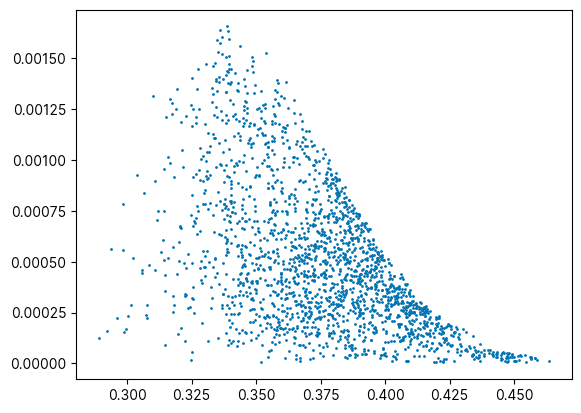

In [344]:
plt.plot(particles[:, 0], weights[:], ".", ms=2)

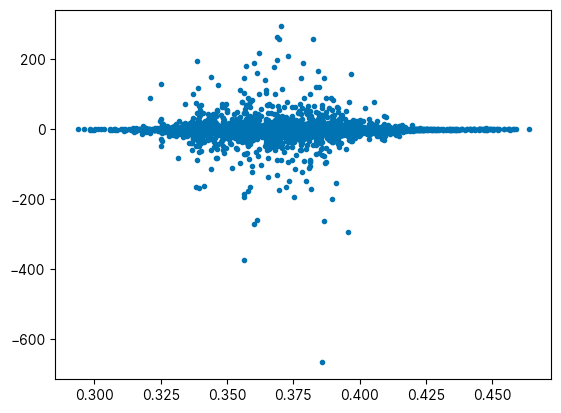

In [345]:
plt.plot(sort_pars_axis[2:], finite_diff, ".")
# plt.yscale('log')

In [305]:
finite_diff

array([  85.16904,  227.75792,  125.18177, ..., 1696.0475 ,  919.81036,
         94.34011], dtype=float32)

In [291]:
sort_pars_axis.shape

(2000,)

In [295]:
sort_pars_axis

array([0.28893307, 0.29236436, 0.29365298, ..., 0.45827767, 0.4587764 ,
       0.46369135], dtype=float32)

In [299]:
np.abs(sort_pars_axis[0:-1] - sort_pars_axis[1:])

array([0.00343129, 0.00128862, 0.00236017, ..., 0.00027019, 0.00049874,
       0.00491494], dtype=float32)

In [289]:
np.sort(
    particles[:, 0],
)

array([0.28893307, 0.29236436, 0.29365298, ..., 0.45827767, 0.4587764 ,
       0.46369135], dtype=float32)

In [281]:
particles

array([[ 0.33713898,  0.43307042,  0.08512942, -0.29017964],
       [ 0.35848066,  0.38078296,  0.02378253, -0.3380637 ],
       [ 0.37889543,  0.42055026,  0.08332042, -0.2941326 ],
       ...,
       [ 0.34442228,  0.34636754,  0.05960167, -0.33510366],
       [ 0.39145318,  0.40037778,  0.0825014 , -0.26942176],
       [ 0.40048626,  0.3498751 ,  0.07760929, -0.34405458]],
      dtype=float32)

In [276]:
arr.weights[0]

Array([1.0411928e-03, 2.0489396e-04, 8.8691292e-04, ..., 4.7467925e-04,
       5.5402599e-04, 3.6970334e-05], dtype=float32)

In [273]:
arr

Run(
  iteration=i32[5],
  key=u32[5,2],
  weights=f32[5,2000],
  particles_locations=f32[5,2000,4],
  max_iterations=i32[5],
  min_iterations=i32[5],
  std_threshold=f32[5],
  cov_array=f32[5,5000,4,4],
  estimates_array=f32[5,5000,4],
  times_array=f32[5,5000]
)

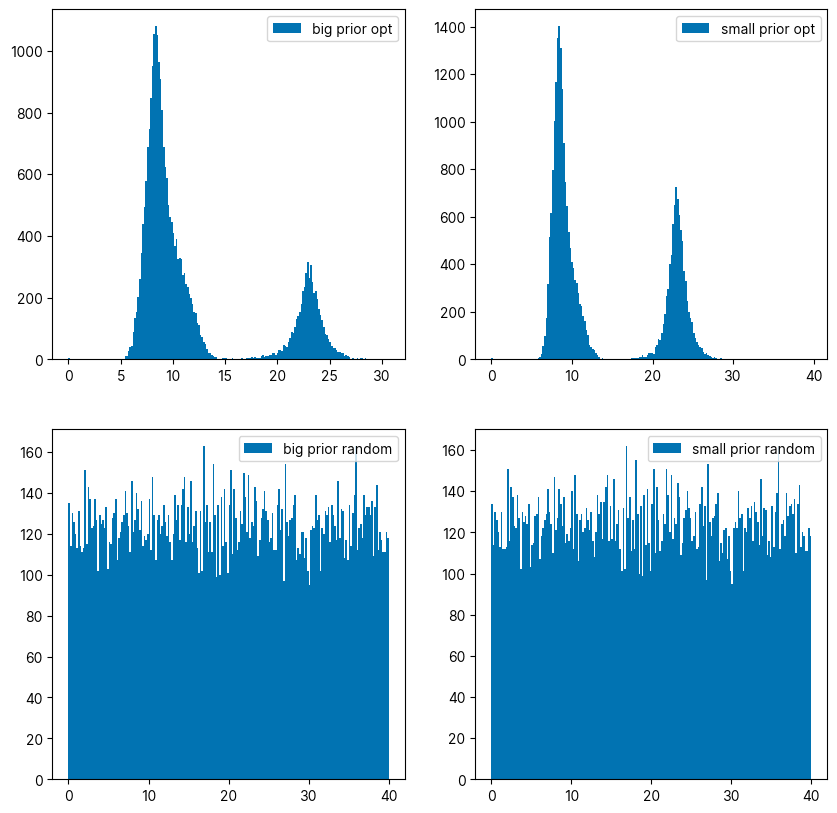

In [266]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for i, ax in enumerate(axs.flat):
    ax.hist(
        np.array(all_df[i].times_array).flatten(), label=info_list[i], bins=200
    )
    ax.legend()
# plt.legend()
plt.show()